# 94812 Applications of NL(X) and LLM - Personal Assignment 1
Author: Yi-Hsueh(Alex) Yang

## Objective:

To build a stock price prediction model incorporating both historical data and social media sentiment, evaluate its accuracy on the GameStop short squeeze, and analyze potential improvements based on the event.



## Data Preparation

In [557]:
import json
import requests
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

The forecast timeframe to cover June 2021 through August 2021, a total of 90 days. 



In [558]:
# get stock data
tickers = 'GME'
tickerData = yf.Ticker(tickers)
psuedo_start_date = '2021-01-01'
start_date = '2021-06-01'
end_date = '2021-09-01'

tickerDF = tickerData.history(period='1d', start=start_date, end=end_date)
fullDF = tickerData.history(period='1d', start=psuedo_start_date, end=end_date)
tickerDF.index = pd.to_datetime(tickerDF.index).tz_localize(None).date
fullDF.index = pd.to_datetime(fullDF.index).tz_localize(None).date
print(len(tickerDF))
print(len(fullDF))
tickerDF.tail()

65
167


,Open,High,Low,Close,Volume,Dividends,Stock Splits
2021-08-25,51.662498,56.750000,48.250000,49.912498,51444400,0.0,0.0
2021-08-26,50.169998,54.250000,49.750000,51.305000,24954400,0.0,0.0
2021-08-27,51.924999,53.250000,50.005001,51.237499,12923200,0.0,0.0
2021-08-30,51.250000,54.547501,50.755001,52.299999,13238400,0.0,0.0
2021-08-31,53.174999,55.575001,52.865002,54.560001,14298800,0.0,0.0


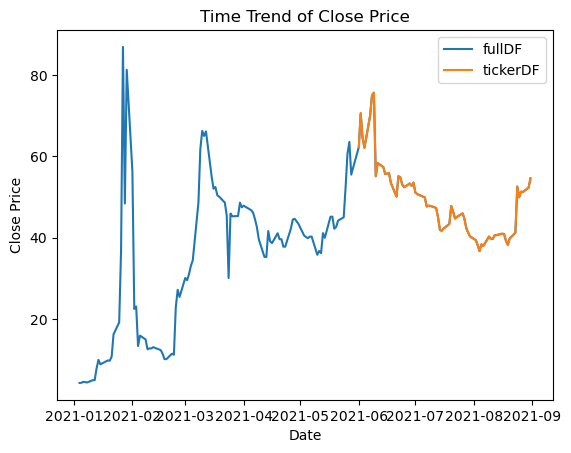

In [559]:
# plot the time trend of Close price for both tickerDF and fullDF
plt.plot(fullDF.index, fullDF['Close'], label='fullDF')
plt.plot(tickerDF.index, tickerDF['Close'], label='tickerDF')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Time Trend of Close Price')
plt.legend()
plt.show()

In [560]:
# read in sentiment data
gme_data = pd.read_csv('data/rGME_dataset_features.csv', encoding='ISO-8859-1', index_col=0)
print(len(gme_data))
gme_data.head()

/var/folders/zs/j91wn79j45lccf78212k1pp80000gn/T/ipykernel_8923/3811426179.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  gme_data = pd.read_csv('data/rGME_dataset_features.csv', encoding='ISO-8859-1', index_col=0)


1033236


,id,title,url,score,author,num_comments,date,flair,compound,neg,...,_poss,_intj,_appos,_npadvmod,_predet,_case,_expl,_oprd,_dative,_nmod
0,kqfajb,You NEED to see this about GME ðððð...,https://www.reddit.com/r/GME/comments/kqfajb/y...,1.0,TitsDownOnly,9.0,2021-01-04,NaN,0.9872,0.000,...,0,0,6,0,0,0,0,0,0,0
1,kqjh2t,Short Squeeze Incoming ðððððð...,/r/wallstreetbets/comments/kqcwdo/gamestops_gr...,1.0,zoomermoney,1.0,2021-01-04,NaN,0.9906,0.000,...,0,0,3,0,0,0,0,0,0,0
2,kqvp7l,THIS CONVINCED ME TO ALL IN ð°GME (EXTREME P...,https://www.reddit.com/r/GME/comments/kqvp7l/t...,1.0,TitsDownOnly,6.0,2021-01-05,NaN,0.5319,0.000,...,0,0,0,0,0,0,0,0,0,0
3,krcwch,You already know what we must do brothers and ...,/r/wallstreetbets/comments/kr98ym/gme_gang_we_...,1.0,dontforgettolive,4.0,2021-01-05,NaN,-0.2960,0.115,...,1,0,0,0,0,0,0,0,0,0
4,krnthg,ICR conference (11th Jan),https://www.reddit.com/r/GME/comments/krnthg/i...,1.0,nicky94,10.0,2021-01-06,NaN,0.0000,0.000,...,0,0,0,1,0,0,0,0,0,0


In [561]:
# filter time period from 2021/06 to 2021/08
gme_small = gme_data[(gme_data.date >= start_date) & (gme_data.date < end_date)]
print(len(gme_small))
gme_small.head()

63662


,id,title,url,score,author,num_comments,date,flair,compound,neg,...,_poss,_intj,_appos,_npadvmod,_predet,_case,_expl,_oprd,_dative,_nmod
937777,npl9f0,An Ape Bought 30k Shares at $227 on Friday for...,https://i.redd.it/xcuoa8p3wk271.png,1.0,hydershykh,98.0,2021-06-01,ð¥ï¸ Terminal | Data ð¥ï¸ð¨âð»,0.8585,0.000,...,0,0,0,0,0,0,0,0,0,1
937778,nplc4a,"Just a Reminder after 4 days! Cant Stop , Wont...",https://www.reddit.com/r/GME/comments/nplc4a/j...,1.0,mauler1983,3.0,2021-06-01,âï¸ Fluff ð,0.4710,0.000,...,0,0,0,1,0,0,0,0,0,0
937779,npld4c,I just decided once the moass hits iâm openi...,https://www.reddit.com/r/GME/comments/npld4c/i...,1.0,gromit2442,22.0,2021-06-01,âï¸ Fluff ð,0.0000,0.000,...,1,0,0,0,0,0,0,0,0,0
937780,nplhbh,I Like The Stock. HODL. Go outside and enjoy t...,https://i.redd.it/s6fbrldgyk271.jpg,1.0,MeRooga850,9.0,2021-06-01,ð ð,0.9322,0.000,...,3,0,1,0,0,0,0,0,0,0
937781,nplk0v,Spacetime T-Shirt! Bias confirmed! Wrinkle bra...,https://i.redd.it/20u7h34azk271.jpg,1.0,Rochatastic,2.0,2021-06-01,ð ð,-0.3129,0.275,...,0,0,0,0,0,0,0,0,0,0


## Model Building

In [562]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow.keras.backend 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
import matplotlib.pyplot as plot

In [563]:
# Normalize the closing prices
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(fullDF['Close'].values.reshape(-1, 1))

In [564]:
# create sequences for LSTM
def create_sequences(data, lookback):
    xs, ys = [], []
    for i in range(len(data)-lookback-1):
        x = data[i:(i+lookback)]
        y = data[i+lookback]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

lookback = 20 # adjustable
x, y = create_sequences(scaled_data, lookback)

train_size = int(len(x) * 0.51) # 65/167
val_size = int(len(x) * 0.1)

x_train, x_temp = x[0:train_size], x[train_size:len(x)]
y_train, y_temp = y[0:train_size], y[train_size:len(y)]

x_val, x_test = x_temp[0:val_size], x_temp[val_size:len(x)]
y_val, y_test = y_temp[0:val_size], y_temp[val_size:len(y)]

In [565]:
# Build the LSTM model
def train_LSTM(x_train, y_train, x_val, y_val, x_test, y_test, loss_func='mean_squared_error', metric=None):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
        LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
        LSTM(50, return_sequences=False),
        Dense(25),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss=loss_func, metrics=metric)

    # Train the model
    model.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_val, y_val))

    # Predicting future prices
    predicted_prices = model.predict(x_test)
    predicted_prices = scaler.inverse_transform(predicted_prices)

    # Calculate errors
    train_error = model.evaluate(x_train, y_train, verbose=0)
    val_error = model.evaluate(x_val, y_val, verbose=0)
    test_error = model.evaluate(x_test, y_test, verbose=0)

    return predicted_prices, train_error, val_error, test_error


# Defining RMSE as a metric
def rmse(y_true, y_pred):
    return tensorflow.keras.backend.sqrt(tensorflow.keras.backend.mean(tensorflow.keras.backend.square(y_pred - y_true)))

In [566]:
# train LSTM models with different loss functions
predicted_prices_MSE, train_error_MSE, val_error_MSE, test_error_MSE = train_LSTM(x_train, y_train, x_val, y_val, x_test, y_test,loss_func='mean_squared_error')
predicted_prices_MAE, train_error_MAE, val_error_MAE, test_error_MAE = train_LSTM(x_train, y_train, x_val, y_val, x_test, y_test, loss_func='mean_absolute_error')
predicted_prices_RMSE, train_error_RMSE, val_error_RMSE, test_error_RMSE = train_LSTM(x_train, y_train, x_val, y_val, x_test, y_test, loss_func='mean_squared_error', metric=[rmse])

Epoch 1/25
3/3 [==============================] - 3s 353ms/step - loss: 0.1886 - val_loss: 0.3224
Epoch 2/25
3/3 [==============================] - 0s 24ms/step - loss: 0.1034 - val_loss: 0.1636
Epoch 3/25
3/3 [==============================] - 0s 25ms/step - loss: 0.0415 - val_loss: 0.0246
Epoch 4/25
3/3 [==============================] - 0s 29ms/step - loss: 0.0400 - val_loss: 0.0225
Epoch 5/25
3/3 [==============================] - 0s 24ms/step - loss: 0.0310 - val_loss: 0.0709
Epoch 6/25
3/3 [==============================] - 0s 23ms/step - loss: 0.0287 - val_loss: 0.1125
Epoch 7/25
3/3 [==============================] - 0s 22ms/step - loss: 0.0340 - val_loss: 0.1075
Epoch 8/25
3/3 [==============================] - 0s 22ms/step - loss: 0.0309 - val_loss: 0.0800
Epoch 9/25
3/3 [==============================] - 0s 22ms/step - loss: 0.0256 - val_loss: 0.0488
Epoch 10/25
3/3 [==============================] - 0s 22ms/step - loss: 0.0264 - val_loss: 0.0337
Epoch 11/25
3/3 [===========

In [567]:
# create a table of all training error, val error and test error from MSE, MAE, and RMSE

loss_comparison = pd.DataFrame({
    'Model': ['MSE', 'MAE', 'RMSE'],
    'Training Error': [train_error_MSE, train_error_MAE, train_error_RMSE[1]],
    'Validation Error': [val_error_MSE, val_error_MAE, val_error_RMSE[1]],
    'Test Error': [test_error_MSE, test_error_MAE, test_error_RMSE[1]]
})

loss_comparison

,Model,Training Error,Validation Error,Test Error
0,MSE,0.024152,0.045932,0.005270
1,MAE,0.104801,0.180248,0.044774
2,RMSE,0.111898,0.245551,0.093239


##

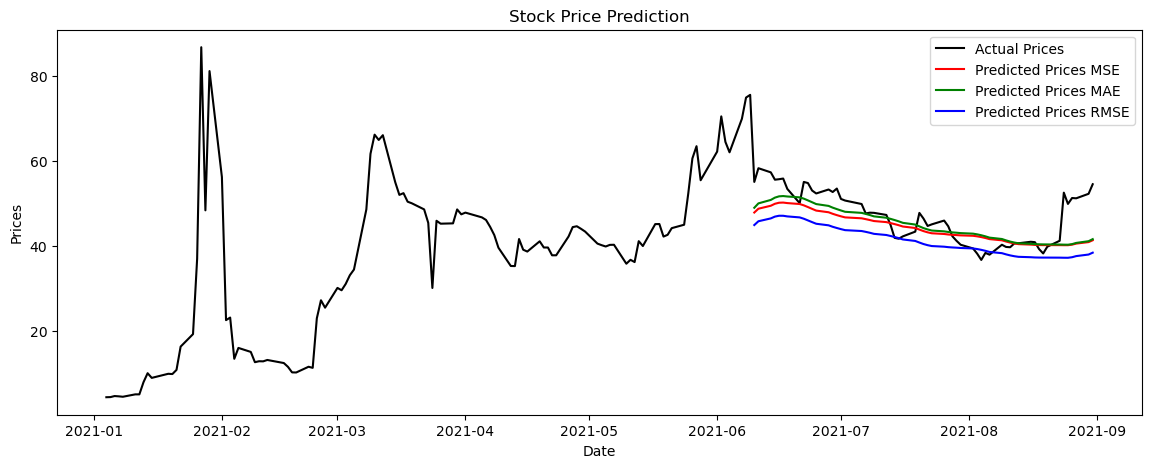

In [568]:
# Plot the prediction of stock price with different loss functions
test_dates = fullDF.index.values[-len(predicted_prices_MSE):]

# Inverse scaling the test data if it was scaled
actual_prices_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotting
plt.figure(figsize=(14, 5))
plt.plot(fullDF.index, scaler.inverse_transform(scaled_data), label="Actual Prices", color='black')
plt.plot(test_dates, predicted_prices_MSE, label="Predicted Prices MSE", color='red')
plt.plot(test_dates, predicted_prices_MAE, label="Predicted Prices MAE", color='green')
plt.plot(test_dates, predicted_prices_RMSE, label="Predicted Prices RMSE", color='blue')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()

In [569]:
# calculate number of business days
full_business_day = fullDF.index.astype(str).tolist()
business_day = tickerDF.index.astype(str).tolist()
print(len(full_business_day))
print(len(business_day))

167
65


### Event Analysis

In [570]:
# filter only the column title, date, score, num_comments, compound, neg, neu, pos, and clean_text
gme_small_filtered = gme_small[['title', 'date', 'score', 'num_comments', 'compound', 'neg', 'neu', 'pos', 'clean_text']]

# filter only the rows with the business day
gme_small_filtered = gme_small_filtered[gme_small_filtered['date'].isin(business_day)]
print(len(gme_small_filtered))
gme_small_filtered.head()

46986


,title,date,score,num_comments,compound,neg,neu,pos,clean_text
937777,An Ape Bought 30k Shares at $227 on Friday for...,2021-06-01,1.0,98.0,0.8585,0.000,0.642,0.358,ape buy 30k share $ 227 Friday 7 million dolla...
937778,"Just a Reminder after 4 days! Cant Stop , Wont...",2021-06-01,1.0,3.0,0.4710,0.000,0.730,0.270,reminder 4 day not stop will nt stop GameStop
937779,I just decided once the moass hits iâm openi...,2021-06-01,1.0,22.0,0.0000,0.000,1.000,0.000,decide moass hit open toy r town
937780,I Like The Stock. HODL. Go outside and enjoy t...,2021-06-01,1.0,9.0,0.9322,0.000,0.720,0.280,like Stock HODL outside enjoy world account gr...
937781,Spacetime T-Shirt! Bias confirmed! Wrinkle bra...,2021-06-01,1.0,2.0,-0.3129,0.275,0.725,0.000,Spacetime T Shirt Bias confirm wrinkle brain a...


In [571]:
# get the average neg, neu and pos for group dates
gme_small_filtered_grouped = gme_small_filtered.groupby('date')[['num_comments','score', 'compound', 'neg','neu','pos']].mean()
gme_small_filtered_grouped.index = pd.to_datetime(gme_small_filtered_grouped.index).tz_localize(None).date

gme_small_filtered_grouped.head()

,num_comments,score,compound,neg,neu,pos
2021-06-01,12.723460,1.026212,0.176447,0.047073,0.804550,0.148383
2021-06-02,16.176318,1.051440,0.135441,0.062058,0.804731,0.133204
2021-06-03,8.431670,2.256508,0.167384,0.053601,0.797932,0.148462
2021-06-04,17.728547,1.026360,0.193930,0.059596,0.792928,0.147489
2021-06-07,9.469197,1.418508,0.128329,0.054054,0.822279,0.123671


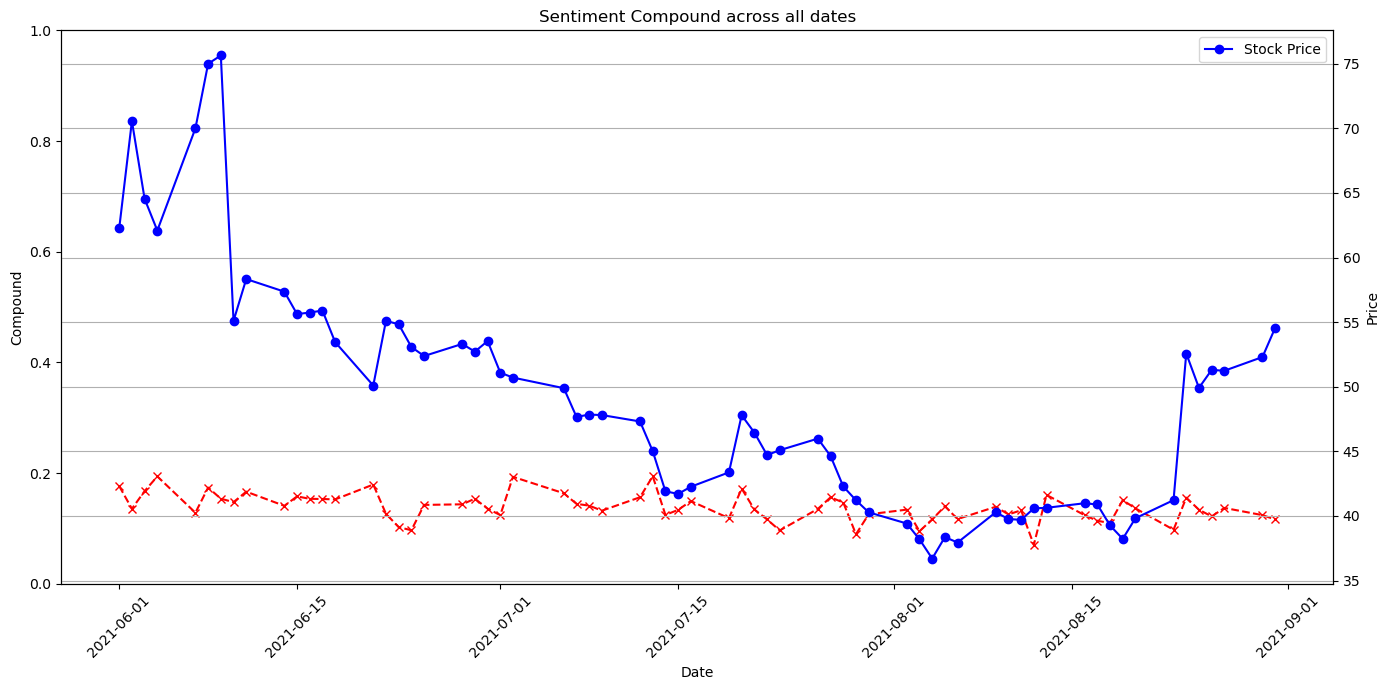

In [572]:
# plot the relationship between compound and stock price across all dates 
plt.figure(figsize=(14, 7))
ax1 = plt.gca()

ax1.plot(gme_small_filtered_grouped.index, gme_small_filtered_grouped['compound'], marker='x', linestyle='--', color='red', label='Diff')
ax1.set_xlabel('Date')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel('Compound')
ax1.tick_params(axis='y')

ax1.set_ylim([0, 1])
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Price') 
ax2.plot(tickerDF.index, tickerDF['Close'], marker='o', linestyle='-', color='blue', label='Stock Price')
ax2.tick_params(axis='y')

plt.title('Sentiment Compound across all dates')  # Title of the plot
plt.grid(True)
plt.legend()
plt.tight_layout()

## Retrospective Predictions and Evaluation

### Combining LSTM Prediction and Sentiment Analysis

In [573]:
# filter time period from 2021/06 to 2021/08
gme_full = gme_data[(gme_data.date >= psuedo_start_date) & (gme_data.date < end_date)]
# filter time period with only day in business_day
gme_full = gme_full[gme_full['date'].isin(full_business_day)]

# group by date
gme_full_grouped = gme_full.groupby('date')[['compound', 'neg', 'neu', 'pos']].mean()

# filter only the rows with the business day
gme_business_day = gme_full_grouped.index.astype(str).tolist()
fullDF.index = fullDF.index.astype(str)
fullDF = fullDF[fullDF.index.isin(gme_business_day)]

In [574]:
# scale the stock data
scaler = MinMaxScaler(feature_range=(-1,1))
fullDF['Close'] = scaler.fit_transform(fullDF['Close'].values.reshape(-1, 1))

daily_stock = np.array(fullDF.Close)
daily_sentiments = np.array(gme_full_grouped.compound)

# combine stock and sentiment
combined_features = np.column_stack((daily_stock, daily_sentiments))
np.shape(combined_features)

(155, 2)

In [575]:
# create sequences of combined features for LSTM
def create_sequences_combined(data, lookback):
    X, Y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:(i + lookback), :])
        Y.append(data[i + lookback, 0])

    return np.array(X), np.array(Y)

x, y = create_sequences_combined(combined_features, lookback)

# There are 148 rows of data from Jan to the end of May
# test: 58
print(x.shape)
test_start = 58
train_end = int(np.ceil((np.shape(x)[0] - test_start) * 0.85))
val_end = np.shape(x)[0] - test_start 

x_train, x_val, x_test = x[0:train_end], x[train_end:val_end], x[val_end:len(x)]
y_train, y_val, y_test = y[0:train_end], y[train_end:val_end], y[val_end:len(y)]

(135, 20, 2)


In [576]:
# train LSTM with combined features
def train_LSTM_combined_model(x_train, y_train, x_val, y_val, x_test, y_test, loss_func='mean_squared_error', metric=None):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
        LSTM(50, return_sequences=True),
        LSTM(50, return_sequences=False),
        Dense(25),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss=loss_func, metrics=metric)
    model.fit(x_train, y_train, epochs=25, batch_size=1, validation_data=(x_val, y_val))
    pred = model.predict(x_test)

    # Calculate errors
    train_error = model.evaluate(x_train, y_train, verbose=0)
    val_error = model.evaluate(x_val, y_val, verbose=0)
    test_error = model.evaluate(x_test, y_test, verbose=0)

    return pred, train_error, val_error, test_error

In [577]:
# train LSTM on combined features with different loss functions
pred_MSE, train_error_MSE, val_error_MSE, test_error_MSE = train_LSTM_combined_model(x_train, y_train, x_val, y_val, x_test, y_test, loss_func='mean_squared_error')
pred_MAE, train_error_MAE, val_error_MAE, test_error_MAE = train_LSTM_combined_model(x_train, y_train, x_val, y_val, x_test, y_test, loss_func='mean_absolute_error')
pred_RMSE, train_error_RMSE, val_error_RMSE, test_error_RMSE = train_LSTM_combined_model(x_train, y_train, x_val, y_val, x_test, y_test, loss_func='mean_squared_error', metric=rmse)

Epoch 1/25
66/66 [==============================] - 4s 18ms/step - loss: 0.1217 - val_loss: 0.2915
Epoch 2/25
66/66 [==============================] - 0s 8ms/step - loss: 0.1177 - val_loss: 0.2823
Epoch 3/25
66/66 [==============================] - 1s 10ms/step - loss: 0.0990 - val_loss: 0.3232
Epoch 4/25
66/66 [==============================] - 0s 7ms/step - loss: 0.0713 - val_loss: 0.2203
Epoch 5/25
66/66 [==============================] - 1s 8ms/step - loss: 0.0500 - val_loss: 0.1221
Epoch 6/25
66/66 [==============================] - 0s 7ms/step - loss: 0.0443 - val_loss: 0.1046
Epoch 7/25
66/66 [==============================] - 0s 7ms/step - loss: 0.0371 - val_loss: 0.1362
Epoch 8/25
66/66 [==============================] - 1s 9ms/step - loss: 0.0258 - val_loss: 0.1476
Epoch 9/25
66/66 [==============================] - 0s 7ms/step - loss: 0.0233 - val_loss: 0.1094
Epoch 10/25
66/66 [==============================] - 0s 7ms/step - loss: 0.0170 - val_loss: 0.0786
Epoch 11/25
66/66

In [578]:
# create a table of all training error, val error and test error from MSE, MAE, and RMSE

loss_comparison = pd.DataFrame({
    'Model': ['MSE', 'MAE', 'RMSE'],
    'Training Error': [train_error_MSE, train_error_MAE, train_error_RMSE[1]],
    'Validation Error': [val_error_MSE, val_error_MAE, val_error_RMSE[1]],
    'Test Error': [test_error_MSE, test_error_MAE, test_error_RMSE[1]]
})

loss_comparison

,Model,Training Error,Validation Error,Test Error
0,MSE,0.010839,0.090890,0.013674
1,MAE,0.057666,0.166876,0.050130
2,RMSE,0.067207,0.227330,0.081761


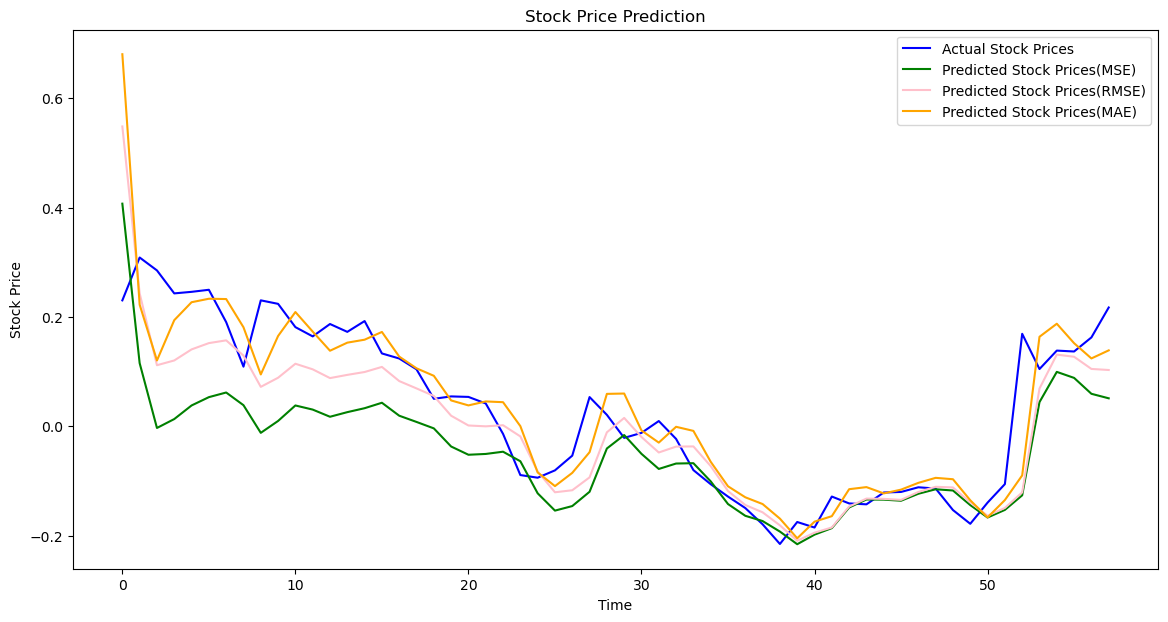

In [579]:
# Predicting future stock prices with different loss functions
plt.figure(figsize=(14, 7))

plt.plot(y_test, label='Actual Stock Prices', color='blue')
plt.plot(pred_MSE, label='Predicted Stock Prices(MSE)', color='green')
plt.plot(pred_RMSE, label='Predicted Stock Prices(RMSE)', color='pink')
plt.plot(pred_MAE, label='Predicted Stock Prices(MAE)', color='orange')

# Label the axes and create a legend
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')
plt.legend()

## GameStop Short Squeeze and Model Adaptation

### Sensitivity Analysis with generated spikes 

In [580]:
# Injecting synthetic sentiment spikes
spike_days = ['2021-07-07', '2021-07-21', '2021-08-18']  # Example spike days
for day in spike_days:
    gme_full_grouped.loc[day, 'compound'] += 0.5  # Adding a spike

In [581]:
# train LSTM with combined features with spikes
def train_combined_model_with_spikes(sentiment_data, stock_data, loss_func='mean_squared_error', metric=None):
    lookback = 20
    
    daily_stock = np.array(stock_data.Close)
    daily_sentiments = np.array(sentiment_data.compound)
    combined_features = np.column_stack((daily_stock, daily_sentiments))
    x, y = create_sequences_combined(combined_features, lookback)

    test_start = 58
    train_end = int(np.ceil((np.shape(x)[0] - test_start) * 0.85))
    val_end = np.shape(x)[0] - test_start 

    x_train, x_val, x_test = x[0:train_end], x[train_end:val_end], x[val_end:len(x)]
    y_train, y_val, y_test = y[0:train_end], y[train_end:val_end], y[val_end:len(y)]

    model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
    LSTM(50, return_sequences=True),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss=loss_func, metrics=metric)

    model.fit(x_train, y_train, epochs=25, batch_size=1, validation_data=(x_val, y_val))

    pred = model.predict(x_test)
    train_error = model.evaluate(x_train, y_train, verbose=0)
    val_error = model.evaluate(x_val, y_val, verbose=0)
    test_error = model.evaluate(x_test, y_test, verbose=0)

    return pred, train_error, val_error, test_error

In [582]:
# train LSTM with combined features with spikes and different loss functions
prediction_MSE_wspike, train_error_MSE_wspike, val_error_MSE_wspike, test_error_MSE_wspike = train_combined_model_with_spikes(gme_full_grouped, fullDF, loss_func='mean_squared_error')
prediction_MAE_wspike, train_error_MAE_wspike, val_error_MAE_wspike, test_error_MAE_wspike = train_combined_model_with_spikes(gme_full_grouped, fullDF, loss_func='mean_absolute_error')
prediction_RMSE_wspike, train_error_RMSE_wspike, val_error_RMSE_wspike, test_error_RMSE_wspike = train_combined_model_with_spikes(gme_full_grouped, fullDF, loss_func='mean_squared_error', metric=rmse)

Epoch 1/25
66/66 [==============================] - 3s 18ms/step - loss: 0.1245 - val_loss: 0.3762
Epoch 2/25
66/66 [==============================] - 0s 7ms/step - loss: 0.1036 - val_loss: 0.2750
Epoch 3/25
66/66 [==============================] - 0s 7ms/step - loss: 0.0806 - val_loss: 0.2021
Epoch 4/25
66/66 [==============================] - 0s 7ms/step - loss: 0.0494 - val_loss: 0.1621
Epoch 5/25
66/66 [==============================] - 0s 7ms/step - loss: 0.0428 - val_loss: 0.1417
Epoch 6/25
66/66 [==============================] - 0s 7ms/step - loss: 0.0335 - val_loss: 0.0704
Epoch 7/25
66/66 [==============================] - 0s 7ms/step - loss: 0.0260 - val_loss: 0.0447
Epoch 8/25
66/66 [==============================] - 0s 7ms/step - loss: 0.0360 - val_loss: 0.0559
Epoch 9/25
66/66 [==============================] - 0s 7ms/step - loss: 0.0188 - val_loss: 0.0478
Epoch 10/25
66/66 [==============================] - 0s 7ms/step - loss: 0.0164 - val_loss: 0.0606
Epoch 11/25
66/66 

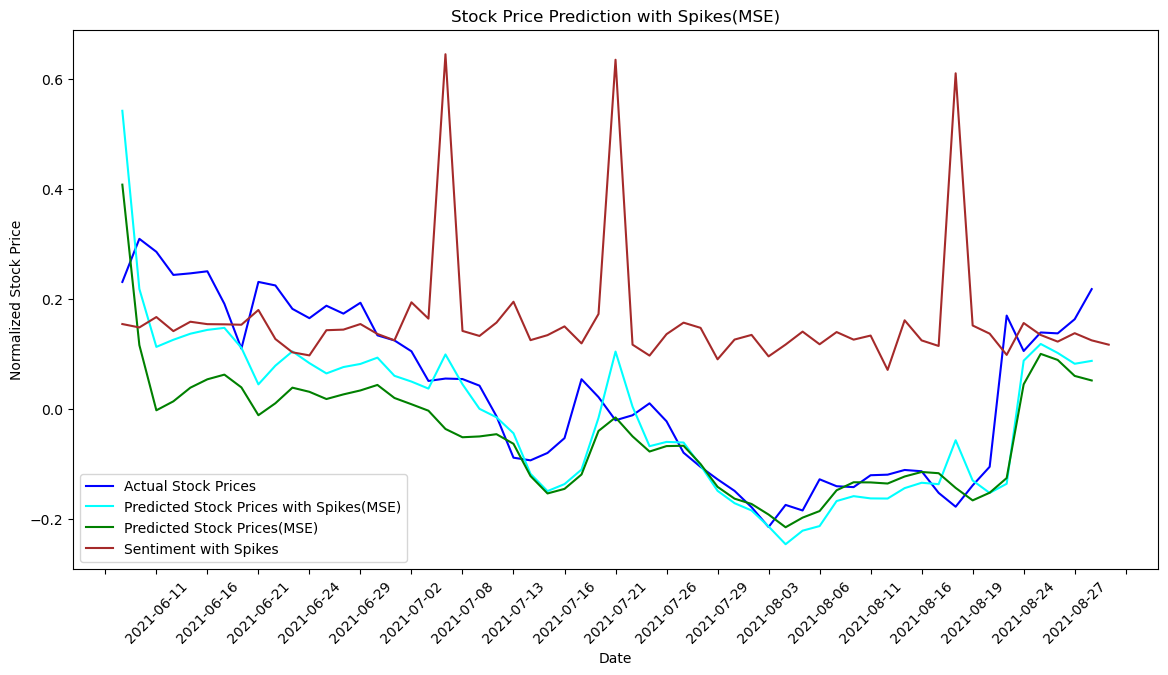

In [583]:
# plot the stock price prediction with spikes with MSE
plt.figure(figsize=(14, 7))

plt.plot(y_test, label='Actual Stock Prices', color='blue')
plt.plot(prediction_MSE_wspike, label='Predicted Stock Prices with Spikes(MSE)', color='cyan')
plt.plot(pred_MSE, label='Predicted Stock Prices(MSE)', color='green')
plt.plot(gme_full_grouped.index[(155-59):], gme_full_grouped.iloc[(155-59):, 0], 
            label='Sentiment with Spikes', color='brown')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))

plt.xlabel('Date')
plt.tick_params(axis='x', rotation=45)
plt.ylabel('Normalized Stock Price')
plt.title('Stock Price Prediction with Spikes(MSE)')
plt.legend()


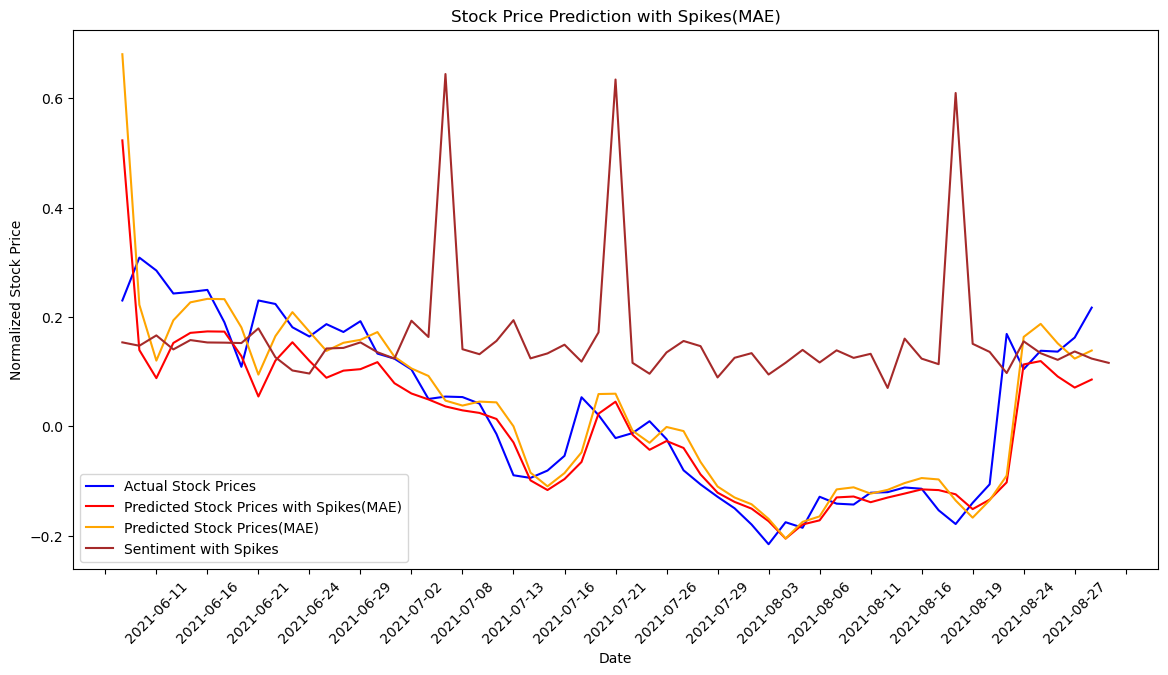

In [584]:
# plot the stock price prediction with spikes with MAE
plt.figure(figsize=(14, 7))

plt.plot(y_test, label='Actual Stock Prices', color='blue')
plt.plot(prediction_MAE_wspike, label='Predicted Stock Prices with Spikes(MAE)', color='red')
plt.plot(pred_MAE, label='Predicted Stock Prices(MAE)', color='orange')
plt.plot(gme_full_grouped.index[(155-59):], gme_full_grouped.iloc[(155-59):, 0], 
            label='Sentiment with Spikes', color='brown')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))

# Label the axes and create a legend
plt.xlabel('Date')
plt.tick_params(axis='x', rotation=45)
plt.ylabel('Normalized Stock Price')
plt.title('Stock Price Prediction with Spikes(MAE)')
plt.legend()


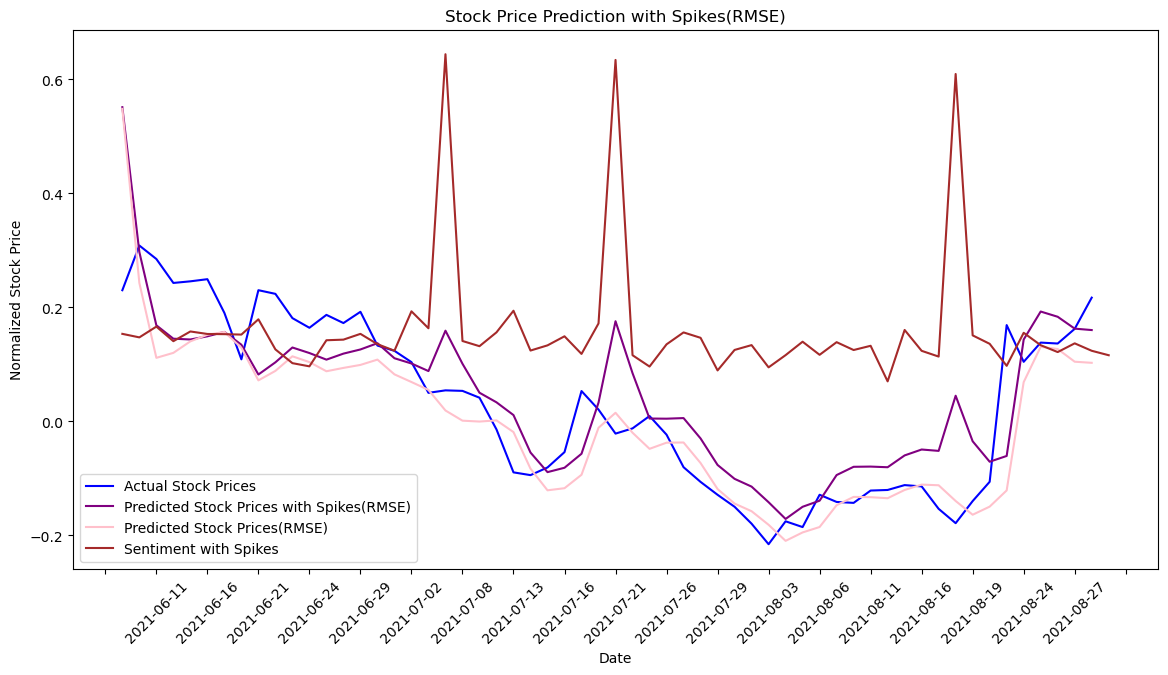

In [585]:
# plot the stock price prediction with spikes with RMSE
plt.figure(figsize=(14, 7))

plt.plot(y_test, label='Actual Stock Prices', color='blue')
plt.plot(prediction_RMSE_wspike, label='Predicted Stock Prices with Spikes(RMSE)', color='purple')
plt.plot(pred_RMSE, label='Predicted Stock Prices(RMSE)', color='pink')
plt.plot(gme_full_grouped.index[(155-59):], gme_full_grouped.iloc[(155-59):, 0], 
            label='Sentiment with Spikes', color='brown')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))

# Label the axes and create a legend
plt.xlabel('Date')
plt.tick_params(axis='x', rotation=45)
plt.ylabel('Normalized Stock Price')
plt.title('Stock Price Prediction with Spikes(RMSE)')
plt.legend()


## Conclusion and Future Directions

There is a total of nine LSTM models trained in this assignment. All using 20 days of lookback when creating sequences. Three basic LSTM models were trained for predicting the stock price with different loss functions(MSE, MAE and RMSE), three were trained on combined datasets (stock price + sentiment score(compound)) to predict the stock price at timestamp t with the data from timestamp t-21 to t-1, with also three different loss functions. Last three models were trained on essentially the same combined dataset but with adding some spikes on three arbitrary dates in the sentiment data deliberately.    

The data is split into three chunks: train, val and test. Training data range from the beginning of the dataset to around mid May, testing data range from 58 days before the end of August (aiming to predict from June 2021 to August 2021 but there only data on business day), and val data ranging from mid May to around late May. Due to the nature of how the data is split, more fluctutations seem to happen in the training set and more tranquility is discovered in the testing set, the training error is always greater than the testing error for the first three models no matter which loss function i use.  

In [586]:
# Error for training LSTM on stock data only

# Model train_error   val_error   test_error
# MSE	 0.024152	  0.045932	  0.005270
# MAE	 0.104801	  0.180248	  0.044774
# RMSE   0.111898	  0.245551	  0.093239

However, the situation is improved as the combined data is trained, the structure of the LSTM remains the same, only changing the input shape of the training data. The model seems to be trained pretty well with a relatively low training and validation error but a slightly higher testing error. 

In [ ]:
# Error for training LSTM on combined dataset

# 	Model  train_error	val_error	test_error
#   MSE	   0.010839	    0.090890	0.013674
#	MAE	   0.057666	    0.166876	0.050130
#	RMSE   0.067207	    0.227330	0.081761

Last three models were trained on combined dataset with spikes, we can see from the graph that the rank of sensitivity towards extreme values for loss function is RMSE > MSE > MAE. All of them predict differently as there is not spike at all, so we can conclude that the model can reflect on the changes in sentiment scores. That being said, the short term rise in sentiment on social media has a power on effecting the stock price and the effect is pretty effective and timely. This is really different from tradition stock price prediction where only price data were used but neglecting many other external factors that has a pretty strong ability in effecting the stock price. 

Therefore, for future research in improving the performance of stock price prediction, the volumn on social media (X, Facebook, etc.) is definitely something one shouldn't miss. Considering the speed of message transmission compare to monthly or annual fiscal report of the company, the changes on social media has the potential to effect stock price in a timely manner. However, once more and more people know about the importance of this now, it is relatively simple for people to manipulate the social volumn in order to control the stock price which is hard to prevent, hence, the way of filtering out noises and irrelevant voices is perhaps a critical issue in the field of stock price prediction in the future.